# Using Pytorch Easily from Scratch! (SegNet)

Import note for the following script: 

The output of the soft-max classifier is a K channel image of probabilities where K is the number of classes. The predicted segmentation corresponds to the class with maximum probability at each pixel. In order to feed the neural network with necessary elements, the masks have to be of the same kind in order for the training to work. 

Learning how to use pytorch in a very easy way, compared to different devices. This utility has the reason to teach how to use pytorch fram scratch. I deduce that tensorflow has a very similar approach

In [1]:
import os
import numpy as np
import scipy
import pandas as pd
import torch
from pathlib import Path
from pprint import pprint
from torchvision import transforms
import matplotlib.pyplot as plt
# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
from PIL import Image
from src.utils_processimage import *
# from albumentations import torch as AT
plt.style.use('bmh')
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# Become one with tha data ! 

Let's understand in a very good way what we are looking at honestly: 


In [2]:
path_example = Path("data/idd20k_lite/train/512")
img = IMG.open(os.path.join(path_example,"frame1434_image.jpg")).convert("RGB")
mask = IMG.open(os.path.join(path_example,"frame1434_inst_label.png")).convert("L")
label_mask = IMG.open(os.path.join(path_example,"frame1434_label.png")).convert("L")

print(f"Shape of the images; {img}")
print(f"Range of the values; {np.max(img),np.min(img)}")
print(f"Shape of the mask; {mask}")
print(f"Range of the mask; {np.min(mask),np.max(mask)}")
print(f"Unique values of mask: {np.unique(mask)}")
print(f"Shape of the label_mask; {label_mask}")
print(f"Range of the label_mask; {np.min(label_mask),np.max(label_mask)}")
print(f"Unique values of label_mask: {np.unique(label_mask)}")

Shape of the images; <PIL.Image.Image image mode=RGB size=320x227 at 0x7FC361028F50>
Range of the values; (255, 0)
Shape of the mask; <PIL.Image.Image image mode=L size=320x227 at 0x7FC361CEBE90>
Range of the mask; (0, 255)
Unique values of mask: [  0   1   2   3   4   5   6 255]
Shape of the label_mask; <PIL.Image.Image image mode=L size=320x227 at 0x7FC360A5B290>
Range of the label_mask; (0, 255)
Unique values of label_mask: [  0   1   2   3   4   5   6 255]


So i have iamge in RBG and then masks with values from 0 to 6 for some classes and 255 as the backgorund ! 

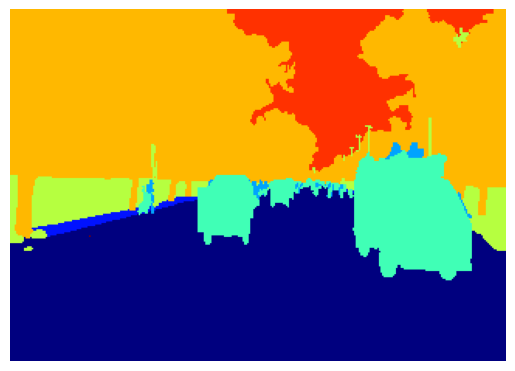

tensor([[[1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         ...,
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000]],

        [[1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         ...,
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000]],

        [[1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         ...,
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         ...,
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000]],

        [[0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.

In [5]:
plot_combined_masks(generate_binary_masks(mask), show_plot=True)

## Loading Images in the `Image Loader`

Turning the image data into a `Dataset` pytorch can use. 

1st: getting a list of all the images under a png fomrat and a jpg fomrat using a function which recusively looks for the specific files. The images will be passed via a list, in the future in an array for faster implemtatnions. 

2nd: the dataclass is loaded so the neural network has as input the original image in RGB and as output the mask with specific ids for each single element. 

In [6]:
import os
from torch.utils.data import Dataset, DataLoader, random_split


# Function which can receive and returns the list of files inside a specific folder
def list_png_files(root_folder, extension):
    png_files = []
    for folder, _, files in os.walk(root_folder):
        if "test" not in folder.lower():
            for file in files:
                if file.lower().endswith(extension) and "_inst" not in file.lower():
                    png_files.append(os.path.join(folder, file))
    return png_files


# Example usage:
root_directory = 'data/idd20k_lite'
png_files_list = list_png_files(root_directory,'.png')
jpg_files_list = list_png_files(root_directory,'.jpg')
print(png_files_list)
print(jpg_files_list)
# error if png filesa re different compared ot jpg files
print("Count of Images: {}".format(len(jpg_files_list)))
print("Count of Masks: {}".format(len(png_files_list)))
print(sorted(png_files_list))
print(sorted(jpg_files_list))

train_dir = 'data/idd20k_lite/train'
val_dir = 'data/idd20k_lite/val'



['data/idd20k_lite/val/181/016719_label.png', 'data/idd20k_lite/val/181/013948_label.png', 'data/idd20k_lite/val/181/001500_label.png', 'data/idd20k_lite/val/181/016119_label.png', 'data/idd20k_lite/val/379/frame46571_label.png', 'data/idd20k_lite/val/379/frame80048_label.png', 'data/idd20k_lite/val/379/frame37118_label.png', 'data/idd20k_lite/val/379/frame28338_label.png', 'data/idd20k_lite/val/379/frame21797_label.png', 'data/idd20k_lite/val/379/frame45784_label.png', 'data/idd20k_lite/val/379/frame9094_label.png', 'data/idd20k_lite/val/379/frame23283_label.png', 'data/idd20k_lite/val/205/frame5153_label.png', 'data/idd20k_lite/val/205/frame5783_label.png', 'data/idd20k_lite/val/533/frame5719_label.png', 'data/idd20k_lite/val/533/frame0079_label.png', 'data/idd20k_lite/val/272/frame0144_label.png', 'data/idd20k_lite/val/172/874002_label.png', 'data/idd20k_lite/val/172/894999_label.png', 'data/idd20k_lite/val/172/178400_label.png', 'data/idd20k_lite/val/172/164487_label.png', 'data/id

# Custom Dataset for Image Segmentation
 
Creating a custom Dataset Subclkass in order to feed to the SegNet a image and a mask

## Making Masks throrugh Segnet 

There is a sublte and very subtle difference when you want to make a final prediction of what is happening. 

In [40]:
LEARNING_RATE = 3e-3
BATCH_SIZE = 4
EPOCHS = 5
# Setup batch size and number of workers 
NUM_WORKERS = os.cpu_count()

In [41]:
def generate_binary_masks(image):
    # Convert PIL image to PyTorch tensor
    image_tensor = torch.tensor(np.array(image))
    
    # Get unique values in the image tensor
    unique_values = torch.unique(image_tensor)
    
    # Initialize an empty tensor to store binary masks
    masks = torch.zeros(8, image_tensor.shape[0], image_tensor.shape[1], dtype=torch.uint8)
    
    # For each unique value, generate a binary mask
    for id_mask, value in enumerate(unique_values):
        masks[id_mask,:,:] = torch.where(image_tensor == value, 1, 0)
    
    return masks

In [42]:
class CarvanaDataset(Dataset):
    def __init__(self, root_directory):
        #getting the root directory of the files
        self.root_directory = root_directory

        # Importing the images from the file list for their extension
        self.images = sorted(list_png_files(root_directory,'.jpg'))
        self.masks = sorted(list_png_files(root_directory,'.png'))

        # applying a resizing for the neural network to understand them better
        self.transform_train = transforms.Compose([
             transforms.Resize((224, 224)),
             transforms.ToTensor()]
            )
        
        # https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
        # Because the input image is scaled to [0.0, 1.0], this transformation should not be used when transforming target image masks. 
        #See the references for implementing the transforms for image masks.
        
        self.transform_test = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(dtype=torch.float32)
        ])

        self.transform_binary = transforms.Compose([
            transforms.Resize((224,224))
        ])
    
    # Get item to pass the images to the dataloader
    def __getitem__(self, index):
        img = IMG.open(self.images[index]).convert("RGB")   # passing the raw image
        masks = IMG.open(self.masks[index]).convert("L")    # passing the only channel mask
        binary_masks = generate_binary_masks(masks)
        

        return self.transform_train(img), self.transform_binary(binary_masks)    # returning the images transformed

    def __len__(self):
    # returning the length of the dataset
        return len(self.images)

In [43]:
dataset = CarvanaDataset(root_directory=root_directory)   # creating the instance
generator = torch.Generator().manual_seed(42)             # adding a generator 

In [44]:
# splitting the dataset into specific elements for train and validation
train_dataset, val_dataset = random_split(dataset, [0.7, 0.3], generator=generator)

# Loading the dataloaders
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

train_dataloader, val_dataloader
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

Creating DataLoader's with batch size 4 and 8 workers.


In [45]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, mask_batch = next(iter(train_dataloader))

## Importing and Testing Model

Testing if the dataloaders work properly and if the neural netword is able to pass a forward inference of the image ! If this work only the training loop is necessary. 

In [46]:
from src.models_seg import SegNet, SegNetMini
from torch import optim, nn
from tqdm import tqdm

model = SegNetMini(classes=8)
# One Put works
x = torch.rand(1,3,224,224) # -> it is tensor
x[0,:,:,:] = img_batch[0]
print(model(x).shape)
output = model(x).detach().numpy()

torch.Size([1, 8, 224, 224])


## PLotting a 1st inference

Let's plot an image and compare it to the original mask, and see what do we get ! 

* Original Mask: [ 3, height, width]
* PLot Image: [ 1, height, width]
* Predicted Mask:  [ 1, height, width]



In [47]:
print("IAMGES:")
print(f"Shape of the images; {img_batch[0].shape}")
min, max= torch.aminmax(img_batch[0])
print(f"Range of the values; {min.item(),max.item()} \n TYPE: {img_batch[0].dtype}\n")

print("MASKS:")
print(f"Shape of the mask; {mask_batch[0].shape}")
min, max= torch.aminmax(mask_batch[0])
print(f"Range of the mask; {min.item(),max.item()} \n  TYPE: {model(x).dtype}\n")

print("MODEL:")
print(f"Shape of the model: {model(x).shape}")
min, max= torch.aminmax(model(x))
print(f"Range of the MODEL; {min.item(),max.item()} \n TYPE: {model(x).dtype} \n\n")

print(f"Shape of the IMAGES in the BATCH: {img_batch.shape} based on the BATCH_SIZE: {BATCH_SIZE} of TYPE:  {img_batch.dtype}\n")
print(f"Shape of the MASK in the BATCH: {mask_batch.shape} based on the BATCH_SIZE: {BATCH_SIZE} of TYPE:  {img_batch.dtype}\n")

IAMGES:
Shape of the images; torch.Size([3, 224, 224])
Range of the values; (0.0, 1.0) 
 TYPE: torch.float32

MASKS:
Shape of the mask; torch.Size([8, 224, 224])


Range of the mask; (0, 1) 
  TYPE: torch.float32

MODEL:
Shape of the model: torch.Size([1, 8, 224, 224])
Range of the MODEL; (-3.7557809352874756, 3.788966178894043) 
 TYPE: torch.float32 


Shape of the IMAGES in the BATCH: torch.Size([4, 3, 224, 224]) based on the BATCH_SIZE: 4 of TYPE:  torch.float32

Shape of the MASK in the BATCH: torch.Size([4, 8, 224, 224]) based on the BATCH_SIZE: 4 of TYPE:  torch.float32



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


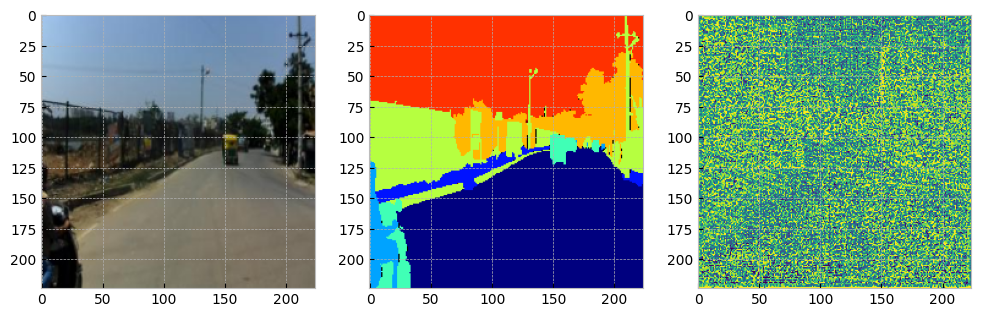

In [48]:
# PLotting one mask compared to the original one to understand if the process is working correctly
plt.figure(figsize=([12,8]))  # PLotting the image in a correct way 
img = img_batch[1]            # Getting the 1st image
img = np.transpose(img,(1,2,0))
rescaled_pred = scipy.special.softmax(output,axis=1)
rescaled_pred = np.argmax(rescaled_pred,axis=1)   # only for inference

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(plot_combined_masks(mask_batch[1])) 
plt.subplot(1,3,3)
plt.imshow(np.transpose(rescaled_pred,(1,2,0)))

This is ain't working not only for the plotting, but also because you have to encode also the masks in some way ! i still have to figure out this specific element let's say ok ?! 

# Training Loop

In [50]:
torch.cuda.empty_cache()   # To empty all the cache in th GPU 
model = SegNet(classes=8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        
        y_pred = model.postprocessing(y_pred)
        optimizer.zero_grad()

        #print(f"OUTPUT SHAPE: {y_pred.shape} and TYPE: {y_pred.dtype}")
        #print(f"OUTPUT SHAPE: {y_pred.shape} and TYPE: {y_pred.dtype}")
        loss = criterion(y_pred, mask)
        #print(f"LOSS: {loss.item()} for {idx}")
        train_running_loss += loss.item()

         
        loss.backward()    # computed the gradients based on the criterion
        optimizer.step()   # After computing the gradients using loss.backward(), the next step is to update the model parameters (weights and biases) using an optimization algorithm.
 
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            
            y_pred = model(img)
            y_pred = model.postprocessing(y_pred)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)

# torch.save(model.state_dict(), MODEL_SAVE_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]

LOSS: 0.3969504237174988 for 0


LOSS: 0.37686875462532043 for 1


LOSS: 0.34842222929000854 for 2


LOSS: 0.3404146134853363 for 3


LOSS: 0.31620675325393677 for 4


LOSS: 0.31727465987205505 for 5


LOSS: 0.33520370721817017 for 6


LOSS: 0.38294413685798645 for 7


LOSS: 0.3001900613307953 for 8


LOSS: 0.3257763087749481 for 9


LOSS: 0.30503323674201965 for 10


LOSS: 0.36666253209114075 for 11


LOSS: 0.3105519711971283 for 12


LOSS: 0.33252981305122375 for 13


LOSS: 0.28430747985839844 for 14


LOSS: 0.2703988254070282 for 15


LOSS: 0.3748301863670349 for 16


LOSS: 0.2731189727783203 for 17


LOSS: 0.27908825874328613 for 18


LOSS: 0.3156217336654663 for 19


LOSS: 0.3388296961784363 for 20


LOSS: 0.3065048158168793 for 21


LOSS: 0.26362526416778564 for 22


LOSS: 0.254095196723938 for 23


LOSS: 0.2511831521987915 for 24


LOSS: 0.25826743245124817 for 25


LOSS: 0.28537365794181824 for 26


LOSS: 0.26008573174476624 for 27


LOSS: 0.2628040015697479 for 28


LOSS: 0.2307499796152115 for 29


LOSS: 0.24465271830558777 for 30


LOSS: 0.2660999000072479 for 31


LOSS: 0.2253081351518631 for 32


LOSS: 0.23049817979335785 for 33


LOSS: 0.24007046222686768 for 34


LOSS: 0.2737163007259369 for 35


LOSS: 0.27319860458374023 for 36


LOSS: 0.21057996153831482 for 37


LOSS: 0.25377586483955383 for 38


LOSS: 0.24680878221988678 for 39


LOSS: 0.2520501911640167 for 40


LOSS: 0.196050763130188 for 41


LOSS: 0.2513691484928131 for 42


LOSS: 0.1951933056116104 for 43


LOSS: 0.2117568701505661 for 44


LOSS: 0.24738894402980804 for 45


LOSS: 0.20755501091480255 for 46


LOSS: 0.27606162428855896 for 47


LOSS: 0.2626470923423767 for 48


LOSS: 0.2405281364917755 for 49


LOSS: 0.23562557995319366 for 50


LOSS: 0.19601772725582123 for 51


LOSS: 0.20384986698627472 for 52


LOSS: 0.1963697373867035 for 53


LOSS: 0.24495533108711243 for 54


LOSS: 0.24585840106010437 for 55


LOSS: 0.24604137241840363 for 56


LOSS: 0.17209920287132263 for 57


LOSS: 0.21867989003658295 for 58


LOSS: 0.20211468636989594 for 59


LOSS: 0.247444748878479 for 60


LOSS: 0.1859595775604248 for 61


LOSS: 0.20101375877857208 for 62


LOSS: 0.18552075326442719 for 63


LOSS: 0.21811245381832123 for 64


LOSS: 0.20352575182914734 for 65


LOSS: 0.22658126056194305 for 66


LOSS: 0.22890596091747284 for 67


LOSS: 0.18971557915210724 for 68


LOSS: 0.2644171118736267 for 69


LOSS: 0.1999809443950653 for 70


LOSS: 0.2071700394153595 for 71


LOSS: 0.2601982355117798 for 72


LOSS: 0.20517295598983765 for 73


LOSS: 0.20668131113052368 for 74


LOSS: 0.18728193640708923 for 75


LOSS: 0.18874651193618774 for 76


LOSS: 0.1851956844329834 for 77


LOSS: 0.2224322259426117 for 78


LOSS: 0.23597176373004913 for 79


LOSS: 0.14810119569301605 for 80


LOSS: 0.2056012749671936 for 81


LOSS: 0.21750052273273468 for 82


LOSS: 0.23992830514907837 for 83


LOSS: 0.28726476430892944 for 84


LOSS: 0.24051526188850403 for 85


LOSS: 0.23117703199386597 for 86


LOSS: 0.2425936460494995 for 87


LOSS: 0.2237594723701477 for 88


LOSS: 0.22062508761882782 for 89


LOSS: 0.19681501388549805 for 90


LOSS: 0.2532651126384735 for 91


LOSS: 0.24450531601905823 for 92


LOSS: 0.25010132789611816 for 93


LOSS: 0.2485836148262024 for 94


LOSS: 0.18438409268856049 for 95


LOSS: 0.19890227913856506 for 96


LOSS: 0.21353989839553833 for 97


LOSS: 0.22944071888923645 for 98


LOSS: 0.18118345737457275 for 99


LOSS: 0.26137280464172363 for 100


LOSS: 0.21678663790225983 for 101


LOSS: 0.19225217401981354 for 102


LOSS: 0.24832779169082642 for 103


LOSS: 0.1885736733675003 for 104


LOSS: 0.23121505975723267 for 105


LOSS: 0.20077763497829437 for 106


LOSS: 0.2055899202823639 for 107


LOSS: 0.19785277545452118 for 108


LOSS: 0.20929758250713348 for 109


LOSS: 0.20289136469364166 for 110


LOSS: 0.19930791854858398 for 111


LOSS: 0.1965358406305313 for 112


LOSS: 0.197211354970932 for 113


LOSS: 0.24780674278736115 for 114


LOSS: 0.1797347366809845 for 115


LOSS: 0.24115557968616486 for 116


LOSS: 0.20162604749202728 for 117


LOSS: 0.2721286118030548 for 118


LOSS: 0.19605858623981476 for 119


LOSS: 0.16568736732006073 for 120


LOSS: 0.2120041698217392 for 121


LOSS: 0.23892290890216827 for 122


LOSS: 0.18420197069644928 for 123


LOSS: 0.20426954329013824 for 124


LOSS: 0.19911602139472961 for 125


LOSS: 0.21616047620773315 for 126


LOSS: 0.1826176941394806 for 127


LOSS: 0.2139512598514557 for 128


LOSS: 0.18221060931682587 for 129


LOSS: 0.2994309663772583 for 130


LOSS: 0.30328369140625 for 131


LOSS: 0.19167791306972504 for 132


LOSS: 0.22103844583034515 for 133


LOSS: 0.21510203182697296 for 134


LOSS: 0.21512483060359955 for 135


LOSS: 0.22455942630767822 for 136


LOSS: 0.2002498209476471 for 137


LOSS: 0.23382283747196198 for 138


LOSS: 0.18770213425159454 for 139


LOSS: 0.22700272500514984 for 140


LOSS: 0.21117201447486877 for 141


LOSS: 0.2583048641681671 for 142


LOSS: 0.21161328256130219 for 143


LOSS: 0.2365957349538803 for 144


LOSS: 0.22332505881786346 for 145


LOSS: 0.19875814020633698 for 146


LOSS: 0.19783295691013336 for 147


LOSS: 0.2181195169687271 for 148


LOSS: 0.21426597237586975 for 149


LOSS: 0.24187776446342468 for 150


LOSS: 0.2595573663711548 for 151


LOSS: 0.18840664625167847 for 152


LOSS: 0.1768609583377838 for 153


LOSS: 0.21972502768039703 for 154


LOSS: 0.2300567626953125 for 155


LOSS: 0.19829687476158142 for 156


LOSS: 0.20872308313846588 for 157


LOSS: 0.21984323859214783 for 158


LOSS: 0.2572891116142273 for 159


LOSS: 0.2410935014486313 for 160


LOSS: 0.20074182748794556 for 161


LOSS: 0.1956152319908142 for 162


LOSS: 0.2857157289981842 for 163


LOSS: 0.18520279228687286 for 164


LOSS: 0.18600104749202728 for 165


LOSS: 0.18607039749622345 for 166


LOSS: 0.16715458035469055 for 167


LOSS: 0.20455172657966614 for 168


LOSS: 0.17692919075489044 for 169


LOSS: 0.19126302003860474 for 170


LOSS: 0.1718653440475464 for 171


LOSS: 0.2143569439649582 for 172


LOSS: 0.2093101143836975 for 173


LOSS: 0.19068723917007446 for 174


LOSS: 0.23052293062210083 for 175


LOSS: 0.22966314852237701 for 176


LOSS: 0.2732311189174652 for 177


LOSS: 0.23286928236484528 for 178


LOSS: 0.19529902935028076 for 179


LOSS: 0.26889294385910034 for 180


LOSS: 0.2214476466178894 for 181


LOSS: 0.24216584861278534 for 182


LOSS: 0.20877724885940552 for 183


LOSS: 0.197491854429245 for 184


LOSS: 0.21975377202033997 for 185


LOSS: 0.21699683368206024 for 186


LOSS: 0.20955303311347961 for 187


LOSS: 0.22048556804656982 for 188


LOSS: 0.19383344054222107 for 189


LOSS: 0.20672988891601562 for 190


LOSS: 0.264596164226532 for 191


LOSS: 0.18628260493278503 for 192


LOSS: 0.18021056056022644 for 193


LOSS: 0.26148316264152527 for 194


LOSS: 0.15311415493488312 for 195


LOSS: 0.18505258858203888 for 196


LOSS: 0.23800569772720337 for 197


LOSS: 0.28719285130500793 for 198


LOSS: 0.19741663336753845 for 199


LOSS: 0.2150980681180954 for 200


LOSS: 0.25350865721702576 for 201


LOSS: 0.24917972087860107 for 202


LOSS: 0.18916790187358856 for 203


LOSS: 0.20650888979434967 for 204


LOSS: 0.24544817209243774 for 205


LOSS: 0.20090650022029877 for 206


LOSS: 0.30434927344322205 for 207


LOSS: 0.1910705268383026 for 208


LOSS: 0.24054044485092163 for 209


LOSS: 0.18757116794586182 for 210


LOSS: 0.2337861955165863 for 211


LOSS: 0.19584830105304718 for 212


LOSS: 0.1939992606639862 for 213


LOSS: 0.19120948016643524 for 214


LOSS: 0.21770073473453522 for 215


LOSS: 0.1963404417037964 for 216


LOSS: 0.2017126977443695 for 217


LOSS: 0.23653016984462738 for 218


LOSS: 0.22028836607933044 for 219


LOSS: 0.24030977487564087 for 220


LOSS: 0.1960606873035431 for 221


LOSS: 0.2409546822309494 for 222


LOSS: 0.219777449965477 for 223


LOSS: 0.2495955526828766 for 224


LOSS: 0.17748072743415833 for 225


LOSS: 0.19438567757606506 for 226


LOSS: 0.2889782190322876 for 227


LOSS: 0.2175331711769104 for 228


LOSS: 0.21443712711334229 for 229


LOSS: 0.17844589054584503 for 230


LOSS: 0.24997040629386902 for 231


LOSS: 0.17116647958755493 for 232


LOSS: 0.19981352984905243 for 233


LOSS: 0.2062191367149353 for 234


LOSS: 0.19606076180934906 for 235


LOSS: 0.28988760709762573 for 236


LOSS: 0.20058290660381317 for 237


LOSS: 0.20057760179042816 for 238


LOSS: 0.211853489279747 for 239


LOSS: 0.23052014410495758 for 240


LOSS: 0.21495720744132996 for 241


LOSS: 0.20426103472709656 for 242


LOSS: 0.18668489158153534 for 243


LOSS: 0.2478674203157425 for 244


LOSS: 0.2249540239572525 for 245


LOSS: 0.2288537323474884 for 246


LOSS: 0.229226753115654 for 247


LOSS: 0.21216750144958496 for 248


LOSS: 0.19664058089256287 for 249


LOSS: 0.21339234709739685 for 250


LOSS: 0.18113066256046295 for 251


LOSS: 0.21882829070091248 for 252


LOSS: 0.21142138540744781 for 253


LOSS: 0.2073984146118164 for 254


LOSS: 0.16741633415222168 for 255


LOSS: 0.16160421073436737 for 256


LOSS: 0.19398047029972076 for 257


LOSS: 0.2182900309562683 for 258


LOSS: 0.21399162709712982 for 259


LOSS: 0.2105022370815277 for 260


LOSS: 0.2172962874174118 for 261


LOSS: 0.22226393222808838 for 262


LOSS: 0.15981194376945496 for 263


LOSS: 0.17274661362171173 for 264


LOSS: 0.19548901915550232 for 265


LOSS: 0.23009708523750305 for 266


LOSS: 0.22820588946342468 for 267


LOSS: 0.2026466578245163 for 268


LOSS: 0.2183726578950882 for 269


LOSS: 0.17044903337955475 for 270


LOSS: 0.20395636558532715 for 271


LOSS: 0.19600379467010498 for 272


LOSS: 0.21258851885795593 for 273


LOSS: 0.19370441138744354 for 274


LOSS: 0.18227554857730865 for 275


LOSS: 0.1903524100780487 for 276


LOSS: 0.18079306185245514 for 277


LOSS: 0.22559036314487457 for 278


LOSS: 0.2327955812215805 for 279


LOSS: 0.19195380806922913 for 280


100%|██████████| 282/282 [06:59<00:00,  1.49s/it]


LOSS: 0.2687161862850189 for 281


 20%|██        | 1/5 [08:25<33:41, 505.30s/it]

------------------------------
Train Loss EPOCH 1: 0.2263
Valid Loss EPOCH 1: 0.2153
------------------------------


LOSS: 0.2205069363117218 for 0


LOSS: 0.24097251892089844 for 1


LOSS: 0.1987966001033783 for 2


LOSS: 0.2540731430053711 for 3


LOSS: 0.25711771845817566 for 4


LOSS: 0.213553324341774 for 5


LOSS: 0.24051553010940552 for 6


LOSS: 0.26053154468536377 for 7


LOSS: 0.1839614361524582 for 8


LOSS: 0.21517515182495117 for 9


LOSS: 0.22919604182243347 for 10


LOSS: 0.2129853218793869 for 11


LOSS: 0.17553655803203583 for 12


LOSS: 0.21458224952220917 for 13


LOSS: 0.23188535869121552 for 14


LOSS: 0.2126052975654602 for 15


LOSS: 0.1968696266412735 for 16


LOSS: 0.23746058344841003 for 17


LOSS: 0.18038837611675262 for 18


LOSS: 0.22542203962802887 for 19


LOSS: 0.1711846888065338 for 20


LOSS: 0.20571038126945496 for 21


LOSS: 0.19340136647224426 for 22


LOSS: 0.17335817217826843 for 23


LOSS: 0.2128169685602188 for 24


LOSS: 0.1911294013261795 for 25


LOSS: 0.19715189933776855 for 26


LOSS: 0.2144327312707901 for 27


LOSS: 0.21402432024478912 for 28


LOSS: 0.1792180985212326 for 29


LOSS: 0.1836395561695099 for 30


LOSS: 0.23237282037734985 for 31


LOSS: 0.17921403050422668 for 32


LOSS: 0.273958683013916 for 33


LOSS: 0.2765326201915741 for 34


LOSS: 0.24618907272815704 for 35


LOSS: 0.20798714458942413 for 36


LOSS: 0.22826331853866577 for 37


LOSS: 0.22709503769874573 for 38


LOSS: 0.2335217148065567 for 39


LOSS: 0.22561855614185333 for 40


LOSS: 0.22989089787006378 for 41


LOSS: 0.22599376738071442 for 42


LOSS: 0.2153303474187851 for 43


LOSS: 0.2000737488269806 for 44


LOSS: 0.256609708070755 for 45


LOSS: 0.1976117044687271 for 46


LOSS: 0.1918400377035141 for 47


LOSS: 0.1897575408220291 for 48


LOSS: 0.24322672188282013 for 49


LOSS: 0.22840139269828796 for 50


LOSS: 0.20691563189029694 for 51


LOSS: 0.22290626168251038 for 52


LOSS: 0.20179998874664307 for 53


LOSS: 0.21215924620628357 for 54


LOSS: 0.20015081763267517 for 55


LOSS: 0.16072656214237213 for 56


LOSS: 0.2992200255393982 for 57


LOSS: 0.25097423791885376 for 58


LOSS: 0.17293351888656616 for 59


LOSS: 0.1919829249382019 for 60


LOSS: 0.16875071823596954 for 61


LOSS: 0.22037692368030548 for 62


LOSS: 0.24029619991779327 for 63


LOSS: 0.17758587002754211 for 64


LOSS: 0.17372316122055054 for 65


LOSS: 0.18234696984291077 for 66


LOSS: 0.21959927678108215 for 67


LOSS: 0.19353266060352325 for 68


LOSS: 0.1965465098619461 for 69


LOSS: 0.16976158320903778 for 70


LOSS: 0.17980186641216278 for 71


LOSS: 0.16939522325992584 for 72


LOSS: 0.15952293574810028 for 73


LOSS: 0.17787669599056244 for 74


LOSS: 0.23728853464126587 for 75


LOSS: 0.2677704393863678 for 76


LOSS: 0.23965029418468475 for 77


LOSS: 0.21510329842567444 for 78


LOSS: 0.2107275277376175 for 79


LOSS: 0.17895154654979706 for 80


LOSS: 0.2023434042930603 for 81


LOSS: 0.22857387363910675 for 82


LOSS: 0.2072700560092926 for 83


LOSS: 0.20430082082748413 for 84


LOSS: 0.1833576261997223 for 85


LOSS: 0.23038890957832336 for 86


LOSS: 0.18657495081424713 for 87


LOSS: 0.19723764061927795 for 88


LOSS: 0.1696082353591919 for 89


LOSS: 0.2820383608341217 for 90


LOSS: 0.16331493854522705 for 91


LOSS: 0.18999823927879333 for 92


LOSS: 0.2330785095691681 for 93


LOSS: 0.21914058923721313 for 94


LOSS: 0.20149962604045868 for 95


LOSS: 0.18994314968585968 for 96


LOSS: 0.18199266493320465 for 97


LOSS: 0.25340700149536133 for 98


LOSS: 0.20865245163440704 for 99


LOSS: 0.2687462568283081 for 100


LOSS: 0.20242935419082642 for 101


LOSS: 0.21441426873207092 for 102


LOSS: 0.22058972716331482 for 103


LOSS: 0.21844244003295898 for 104


LOSS: 0.2444009780883789 for 105


LOSS: 0.22533337771892548 for 106


LOSS: 0.21108543872833252 for 107


LOSS: 0.21195119619369507 for 108


LOSS: 0.19634850323200226 for 109


LOSS: 0.3040910065174103 for 110


LOSS: 0.18610705435276031 for 111


LOSS: 0.21680349111557007 for 112


LOSS: 0.20821869373321533 for 113


LOSS: 0.15437959134578705 for 114


LOSS: 0.1970779448747635 for 115


LOSS: 0.2901189625263214 for 116


LOSS: 0.2076910138130188 for 117


LOSS: 0.23736058175563812 for 118


LOSS: 0.2574767768383026 for 119


LOSS: 0.17772896587848663 for 120


LOSS: 0.2286655753850937 for 121


LOSS: 0.21777595579624176 for 122


LOSS: 0.1822250485420227 for 123


LOSS: 0.20701396465301514 for 124


LOSS: 0.22397500276565552 for 125


LOSS: 0.22298337519168854 for 126


LOSS: 0.18388214707374573 for 127


LOSS: 0.18279317021369934 for 128


LOSS: 0.2500579059123993 for 129


LOSS: 0.3057461977005005 for 130


LOSS: 0.23997452855110168 for 131


LOSS: 0.21037304401397705 for 132


LOSS: 0.22080929577350616 for 133


LOSS: 0.2193855494260788 for 134


LOSS: 0.2160969376564026 for 135


LOSS: 0.17485885322093964 for 136


LOSS: 0.21626800298690796 for 137


LOSS: 0.21627064049243927 for 138


LOSS: 0.2029874473810196 for 139


LOSS: 0.2068951278924942 for 140


LOSS: 0.17199581861495972 for 141


LOSS: 0.23323588073253632 for 142


LOSS: 0.26057496666908264 for 143


LOSS: 0.19121228158473969 for 144


LOSS: 0.20828427374362946 for 145


LOSS: 0.19758282601833344 for 146


LOSS: 0.21337637305259705 for 147


LOSS: 0.16979829967021942 for 148


LOSS: 0.18585683405399323 for 149


LOSS: 0.20731426775455475 for 150


LOSS: 0.18160177767276764 for 151


LOSS: 0.1903776079416275 for 152


LOSS: 0.25036749243736267 for 153


LOSS: 0.20750699937343597 for 154


LOSS: 0.2518811523914337 for 155


LOSS: 0.18779318034648895 for 156


LOSS: 0.19655099511146545 for 157


LOSS: 0.15604455769062042 for 158


LOSS: 0.21855385601520538 for 159


LOSS: 0.22496744990348816 for 160


LOSS: 0.22986960411071777 for 161


LOSS: 0.2514409124851227 for 162


LOSS: 0.21584552526474 for 163


LOSS: 0.19637171924114227 for 164


LOSS: 0.2200525403022766 for 165


LOSS: 0.20102445781230927 for 166


LOSS: 0.2111966758966446 for 167


LOSS: 0.22411498427391052 for 168


LOSS: 0.21967528760433197 for 169


LOSS: 0.21152238547801971 for 170


LOSS: 0.21667927503585815 for 171


LOSS: 0.280704140663147 for 172


LOSS: 0.20404091477394104 for 173


LOSS: 0.21175473928451538 for 174


LOSS: 0.2215183824300766 for 175


LOSS: 0.2015840858221054 for 176


LOSS: 0.22696562111377716 for 177


LOSS: 0.18461887538433075 for 178


LOSS: 0.219632089138031 for 179


LOSS: 0.20862579345703125 for 180


LOSS: 0.21006309986114502 for 181


LOSS: 0.20413826406002045 for 182


LOSS: 0.18157628178596497 for 183


LOSS: 0.21572661399841309 for 184


LOSS: 0.22200219333171844 for 185


LOSS: 0.19841156899929047 for 186


LOSS: 0.23249773681163788 for 187


LOSS: 0.2319301962852478 for 188


LOSS: 0.2890778183937073 for 189


LOSS: 0.19836263358592987 for 190


LOSS: 0.17837423086166382 for 191


LOSS: 0.1976991593837738 for 192


LOSS: 0.19412845373153687 for 193


LOSS: 0.2357431799173355 for 194


LOSS: 0.1711224466562271 for 195


LOSS: 0.22740161418914795 for 196


LOSS: 0.24340364336967468 for 197


LOSS: 0.20965273678302765 for 198


LOSS: 0.18209870159626007 for 199


LOSS: 0.21420831978321075 for 200


LOSS: 0.25248315930366516 for 201


LOSS: 0.1839420199394226 for 202


LOSS: 0.19812960922718048 for 203


LOSS: 0.2474505454301834 for 204


LOSS: 0.2095496505498886 for 205


LOSS: 0.2032930999994278 for 206


LOSS: 0.26741763949394226 for 207


LOSS: 0.2002771645784378 for 208


LOSS: 0.24448245763778687 for 209


LOSS: 0.20395460724830627 for 210


LOSS: 0.19019953906536102 for 211


LOSS: 0.22860495746135712 for 212


LOSS: 0.21377384662628174 for 213


LOSS: 0.20237649977207184 for 214


LOSS: 0.1894245147705078 for 215


LOSS: 0.19724129140377045 for 216


LOSS: 0.2196865826845169 for 217


LOSS: 0.18925568461418152 for 218


LOSS: 0.2034314125776291 for 219


LOSS: 0.20033572614192963 for 220


LOSS: 0.1629824936389923 for 221


LOSS: 0.2084454447031021 for 222


LOSS: 0.17560409009456635 for 223


LOSS: 0.19527451694011688 for 224


LOSS: 0.24719731509685516 for 225


LOSS: 0.1821887046098709 for 226


LOSS: 0.1656627357006073 for 227


LOSS: 0.19092638790607452 for 228


LOSS: 0.164503812789917 for 229


LOSS: 0.18806378543376923 for 230


LOSS: 0.18421658873558044 for 231


LOSS: 0.1634492576122284 for 232


LOSS: 0.23425166308879852 for 233


LOSS: 0.22252923250198364 for 234


LOSS: 0.1862090528011322 for 235


LOSS: 0.18455290794372559 for 236


LOSS: 0.15860813856124878 for 237


LOSS: 0.20564092695713043 for 238


LOSS: 0.16908182203769684 for 239


LOSS: 0.1683599352836609 for 240


LOSS: 0.22615864872932434 for 241


LOSS: 0.23589923977851868 for 242


LOSS: 0.24082425236701965 for 243


LOSS: 0.1667107492685318 for 244


LOSS: 0.18014751374721527 for 245


LOSS: 0.27938446402549744 for 246


LOSS: 0.1927453577518463 for 247


LOSS: 0.19626225531101227 for 248


LOSS: 0.21135038137435913 for 249


LOSS: 0.16442731022834778 for 250


LOSS: 0.17883522808551788 for 251


LOSS: 0.18778111040592194 for 252


LOSS: 0.14492341876029968 for 253


LOSS: 0.22462813556194305 for 254


LOSS: 0.20495936274528503 for 255


LOSS: 0.1802934855222702 for 256


LOSS: 0.21853679418563843 for 257


LOSS: 0.26766952872276306 for 258


LOSS: 0.20485414564609528 for 259


LOSS: 0.20027580857276917 for 260


LOSS: 0.18648193776607513 for 261


LOSS: 0.21084514260292053 for 262


LOSS: 0.23430080711841583 for 263


LOSS: 0.20508240163326263 for 264


LOSS: 0.20030729472637177 for 265


LOSS: 0.18866375088691711 for 266


LOSS: 0.2090015709400177 for 267


LOSS: 0.18435421586036682 for 268


LOSS: 0.1929805874824524 for 269


LOSS: 0.18916304409503937 for 270


LOSS: 0.25361165404319763 for 271


LOSS: 0.1957029551267624 for 272


LOSS: 0.17671647667884827 for 273


LOSS: 0.1926726996898651 for 274


LOSS: 0.16420428454875946 for 275


LOSS: 0.20219163596630096 for 276


LOSS: 0.17311881482601166 for 277


LOSS: 0.21026568114757538 for 278


LOSS: 0.17909131944179535 for 279


LOSS: 0.20378762483596802 for 280


100%|██████████| 282/282 [06:58<00:00,  1.49s/it]


LOSS: 0.22291412949562073 for 281


 40%|████      | 2/5 [16:44<25:05, 501.71s/it]

------------------------------
Train Loss EPOCH 2: 0.2094
Valid Loss EPOCH 2: 0.2053
------------------------------


LOSS: 0.24120420217514038 for 0


LOSS: 0.19083143770694733 for 1


LOSS: 0.23211050033569336 for 2


LOSS: 0.21982227265834808 for 3


LOSS: 0.22677001357078552 for 4


LOSS: 0.2374040186405182 for 5


LOSS: 0.2593041658401489 for 6


LOSS: 0.18273204565048218 for 7


LOSS: 0.19059473276138306 for 8


LOSS: 0.21983429789543152 for 9


LOSS: 0.2503443658351898 for 10


LOSS: 0.2224205881357193 for 11


LOSS: 0.166444331407547 for 12


LOSS: 0.2119283378124237 for 13


LOSS: 0.18649019300937653 for 14


LOSS: 0.19504597783088684 for 15


LOSS: 0.15799520909786224 for 16


LOSS: 0.1998363435268402 for 17


LOSS: 0.21822839975357056 for 18


LOSS: 0.17195402085781097 for 19


LOSS: 0.1997881680727005 for 20


LOSS: 0.18209168314933777 for 21


LOSS: 0.2361084669828415 for 22


LOSS: 0.19430968165397644 for 23


LOSS: 0.21654771268367767 for 24


LOSS: 0.23364175856113434 for 25


LOSS: 0.1915179044008255 for 26


LOSS: 0.24216051399707794 for 27


LOSS: 0.20010638236999512 for 28


LOSS: 0.2098390907049179 for 29


LOSS: 0.20943285524845123 for 30


LOSS: 0.2189243882894516 for 31


LOSS: 0.2710985839366913 for 32


LOSS: 0.19274158775806427 for 33


LOSS: 0.1929859220981598 for 34


LOSS: 0.20192071795463562 for 35


LOSS: 0.18091709911823273 for 36


LOSS: 0.20085793733596802 for 37


LOSS: 0.20621345937252045 for 38


LOSS: 0.19201485812664032 for 39


LOSS: 0.19440844655036926 for 40


LOSS: 0.22403071820735931 for 41


LOSS: 0.2591296434402466 for 42


LOSS: 0.22274795174598694 for 43


LOSS: 0.2170799821615219 for 44


LOSS: 0.19874398410320282 for 45


LOSS: 0.1667693704366684 for 46


LOSS: 0.2590172588825226 for 47


LOSS: 0.29830193519592285 for 48


LOSS: 0.17247909307479858 for 49


LOSS: 0.20669500529766083 for 50


LOSS: 0.1844513863325119 for 51


LOSS: 0.18109183013439178 for 52


LOSS: 0.17851042747497559 for 53


LOSS: 0.19449470937252045 for 54


LOSS: 0.1635369509458542 for 55


LOSS: 0.1592085361480713 for 56


LOSS: 0.2177056074142456 for 57


LOSS: 0.2386462539434433 for 58


LOSS: 0.296082079410553 for 59


LOSS: 0.19878795742988586 for 60


LOSS: 0.26466578245162964 for 61


LOSS: 0.22757647931575775 for 62


LOSS: 0.17526786029338837 for 63


LOSS: 0.2627781331539154 for 64


LOSS: 0.1820562481880188 for 65


LOSS: 0.1903907209634781 for 66


LOSS: 0.23173624277114868 for 67


LOSS: 0.22547738254070282 for 68


LOSS: 0.20267368853092194 for 69


LOSS: 0.184859037399292 for 70


LOSS: 0.1745471954345703 for 71


LOSS: 0.16626161336898804 for 72


LOSS: 0.26620009541511536 for 73


LOSS: 0.19426418840885162 for 74


LOSS: 0.22633495926856995 for 75


LOSS: 0.1691872924566269 for 76


LOSS: 0.16660550236701965 for 77


LOSS: 0.20634208619594574 for 78


LOSS: 0.20228487253189087 for 79


LOSS: 0.16468413174152374 for 80


LOSS: 0.1760101318359375 for 81


LOSS: 0.25239625573158264 for 82


LOSS: 0.20856021344661713 for 83


LOSS: 0.2558830678462982 for 84


LOSS: 0.18371063470840454 for 85


LOSS: 0.17571724951267242 for 86


LOSS: 0.19568686187267303 for 87


LOSS: 0.20319856703281403 for 88


LOSS: 0.21168029308319092 for 89


LOSS: 0.19245681166648865 for 90


LOSS: 0.17156390845775604 for 91


LOSS: 0.21445821225643158 for 92


LOSS: 0.2014104127883911 for 93


LOSS: 0.1789916604757309 for 94


LOSS: 0.18156789243221283 for 95


LOSS: 0.19592763483524323 for 96


LOSS: 0.27280861139297485 for 97


LOSS: 0.19405940175056458 for 98


LOSS: 0.2022627890110016 for 99


LOSS: 0.1732325553894043 for 100


LOSS: 0.2613999545574188 for 101


LOSS: 0.18262380361557007 for 102


LOSS: 0.22815485298633575 for 103


LOSS: 0.17231130599975586 for 104


LOSS: 0.2561897337436676 for 105


LOSS: 0.1905089020729065 for 106


LOSS: 0.19813840091228485 for 107


LOSS: 0.174425408244133 for 108


LOSS: 0.17094434797763824 for 109


LOSS: 0.17449842393398285 for 110


LOSS: 0.18937848508358002 for 111


LOSS: 0.24805808067321777 for 112


LOSS: 0.16594626009464264 for 113


LOSS: 0.20632797479629517 for 114


LOSS: 0.23495323956012726 for 115


LOSS: 0.2029992640018463 for 116


LOSS: 0.20786266028881073 for 117


LOSS: 0.15512868762016296 for 118


LOSS: 0.18268384039402008 for 119


LOSS: 0.16523247957229614 for 120


LOSS: 0.26262593269348145 for 121


LOSS: 0.20581462979316711 for 122


LOSS: 0.15205904841423035 for 123


LOSS: 0.1763518750667572 for 124


LOSS: 0.2742406725883484 for 125


LOSS: 0.21959441900253296 for 126


LOSS: 0.20108801126480103 for 127


LOSS: 0.1886468529701233 for 128


LOSS: 0.19830958545207977 for 129


LOSS: 0.19801823794841766 for 130


LOSS: 0.20354728400707245 for 131


LOSS: 0.2125847041606903 for 132


LOSS: 0.19186770915985107 for 133


LOSS: 0.19202131032943726 for 134


LOSS: 0.2729772925376892 for 135


LOSS: 0.18911345303058624 for 136


LOSS: 0.20769380033016205 for 137


LOSS: 0.19723109900951385 for 138


LOSS: 0.16882522404193878 for 139


LOSS: 0.18678200244903564 for 140


LOSS: 0.169194757938385 for 141


LOSS: 0.22881807386875153 for 142


LOSS: 0.16986985504627228 for 143


LOSS: 0.22556744515895844 for 144


LOSS: 0.17485494911670685 for 145


LOSS: 0.18569910526275635 for 146


LOSS: 0.19572602212429047 for 147


LOSS: 0.19004268944263458 for 148


LOSS: 0.18150386214256287 for 149


LOSS: 0.17822684347629547 for 150


LOSS: 0.16573069989681244 for 151


LOSS: 0.22326885163784027 for 152


LOSS: 0.21769919991493225 for 153


LOSS: 0.2036057710647583 for 154


LOSS: 0.1940557062625885 for 155


LOSS: 0.17448997497558594 for 156


LOSS: 0.18407639861106873 for 157


LOSS: 0.20716510713100433 for 158


LOSS: 0.22872209548950195 for 159


LOSS: 0.22302889823913574 for 160


LOSS: 0.175556018948555 for 161


LOSS: 0.19516806304454803 for 162


LOSS: 0.21082402765750885 for 163


LOSS: 0.17777559161186218 for 164


LOSS: 0.17452433705329895 for 165


LOSS: 0.1669151932001114 for 166


LOSS: 0.2398964911699295 for 167


LOSS: 0.21568915247917175 for 168


LOSS: 0.29114797711372375 for 169


LOSS: 0.16921789944171906 for 170


LOSS: 0.1948617845773697 for 171


LOSS: 0.17960399389266968 for 172


LOSS: 0.2199343740940094 for 173


LOSS: 0.2150462418794632 for 174


LOSS: 0.17121906578540802 for 175


LOSS: 0.20503750443458557 for 176


LOSS: 0.19335398077964783 for 177


LOSS: 0.20519505441188812 for 178


LOSS: 0.2031109631061554 for 179


LOSS: 0.17960408329963684 for 180


LOSS: 0.1913454234600067 for 181


LOSS: 0.20693883299827576 for 182


LOSS: 0.16156528890132904 for 183


LOSS: 0.20597611367702484 for 184


LOSS: 0.2164234071969986 for 185


LOSS: 0.23711474239826202 for 186


LOSS: 0.16126592457294464 for 187


LOSS: 0.14045365154743195 for 188


LOSS: 0.1878300905227661 for 189


LOSS: 0.20865502953529358 for 190


LOSS: 0.1947246491909027 for 191


LOSS: 0.20988431572914124 for 192


LOSS: 0.19813276827335358 for 193


LOSS: 0.2505223751068115 for 194


LOSS: 0.1753309816122055 for 195


LOSS: 0.2341655045747757 for 196


LOSS: 0.31660088896751404 for 197


LOSS: 0.19626538455486298 for 198


LOSS: 0.179539754986763 for 199


LOSS: 0.19781844317913055 for 200


LOSS: 0.21055006980895996 for 201


LOSS: 0.20325173437595367 for 202


LOSS: 0.21028117835521698 for 203


LOSS: 0.15283425152301788 for 204


LOSS: 0.2742680013179779 for 205


LOSS: 0.2082117199897766 for 206


LOSS: 0.19941593706607819 for 207


LOSS: 0.19592000544071198 for 208


LOSS: 0.21187123656272888 for 209


LOSS: 0.26202645897865295 for 210


LOSS: 0.1931416243314743 for 211


LOSS: 0.2018328607082367 for 212


LOSS: 0.16031739115715027 for 213


LOSS: 0.18884168565273285 for 214


LOSS: 0.19709745049476624 for 215


LOSS: 0.18317759037017822 for 216


LOSS: 0.23700784146785736 for 217


LOSS: 0.24647250771522522 for 218


LOSS: 0.2731896638870239 for 219


LOSS: 0.16690409183502197 for 220


LOSS: 0.17230084538459778 for 221


LOSS: 0.17138467729091644 for 222


LOSS: 0.22443048655986786 for 223


LOSS: 0.17942620813846588 for 224


LOSS: 0.18542315065860748 for 225


LOSS: 0.164651557803154 for 226


LOSS: 0.21151970326900482 for 227


LOSS: 0.17363637685775757 for 228


LOSS: 0.1665850281715393 for 229


LOSS: 0.15009580552577972 for 230


LOSS: 0.22766093909740448 for 231


LOSS: 0.2110937386751175 for 232


LOSS: 0.2641373872756958 for 233


LOSS: 0.24491707980632782 for 234


LOSS: 0.2234257310628891 for 235


LOSS: 0.19885915517807007 for 236


LOSS: 0.2036493569612503 for 237


LOSS: 0.1579761803150177 for 238


LOSS: 0.21713773906230927 for 239


LOSS: 0.1794973462820053 for 240


LOSS: 0.1957658976316452 for 241


LOSS: 0.22239992022514343 for 242


LOSS: 0.2639923691749573 for 243


LOSS: 0.19031283259391785 for 244


LOSS: 0.19434690475463867 for 245


LOSS: 0.2119922637939453 for 246


LOSS: 0.17496319115161896 for 247


LOSS: 0.18828964233398438 for 248


LOSS: 0.20487290620803833 for 249


LOSS: 0.18492808938026428 for 250


LOSS: 0.1780245155096054 for 251


LOSS: 0.22646421194076538 for 252


LOSS: 0.23246720433235168 for 253


LOSS: 0.17251116037368774 for 254


LOSS: 0.17585957050323486 for 255


LOSS: 0.19250933825969696 for 256


LOSS: 0.1797255426645279 for 257


LOSS: 0.18013183772563934 for 258


LOSS: 0.19129380583763123 for 259


LOSS: 0.24685454368591309 for 260


LOSS: 0.2531849443912506 for 261


LOSS: 0.1693226546049118 for 262


LOSS: 0.16456851363182068 for 263


LOSS: 0.19190838932991028 for 264


LOSS: 0.22053071856498718 for 265


LOSS: 0.24252218008041382 for 266


LOSS: 0.19395995140075684 for 267


LOSS: 0.21562941372394562 for 268


LOSS: 0.1870618462562561 for 269


LOSS: 0.19976074993610382 for 270


LOSS: 0.19184787571430206 for 271


LOSS: 0.1979777216911316 for 272


LOSS: 0.17104284465312958 for 273


LOSS: 0.2181534767150879 for 274


LOSS: 0.17592722177505493 for 275


LOSS: 0.21995995938777924 for 276


LOSS: 0.24309904873371124 for 277


LOSS: 0.19705355167388916 for 278


LOSS: 0.23310893774032593 for 279


LOSS: 0.20226003229618073 for 280


100%|██████████| 282/282 [06:58<00:00,  1.49s/it]


LOSS: 0.2377406805753708 for 281


 60%|██████    | 3/5 [25:07<16:44, 502.08s/it]

------------------------------
Train Loss EPOCH 3: 0.2035
Valid Loss EPOCH 3: 0.2031
------------------------------


LOSS: 0.2095264345407486 for 0


LOSS: 0.20283706486225128 for 1


LOSS: 0.1760435253381729 for 2


LOSS: 0.18945781886577606 for 3


LOSS: 0.29134950041770935 for 4


LOSS: 0.19630368053913116 for 5


LOSS: 0.18735787272453308 for 6


LOSS: 0.19421641528606415 for 7


LOSS: 0.16630464792251587 for 8


LOSS: 0.2450948804616928 for 9


LOSS: 0.15009504556655884 for 10


LOSS: 0.25385117530822754 for 11


LOSS: 0.2072492241859436 for 12


LOSS: 0.20098254084587097 for 13


LOSS: 0.15986044704914093 for 14


LOSS: 0.1917179822921753 for 15


LOSS: 0.16713957488536835 for 16


LOSS: 0.18163149058818817 for 17


LOSS: 0.1904224008321762 for 18


LOSS: 0.22023989260196686 for 19


LOSS: 0.1440240442752838 for 20


LOSS: 0.2208198606967926 for 21


LOSS: 0.1717280149459839 for 22


LOSS: 0.18258187174797058 for 23


LOSS: 0.19463463127613068 for 24


LOSS: 0.1349397599697113 for 25


LOSS: 0.1566542536020279 for 26


LOSS: 0.1721111238002777 for 27


LOSS: 0.1986648589372635 for 28


LOSS: 0.20512175559997559 for 29


LOSS: 0.24331481754779816 for 30


LOSS: 0.22574202716350555 for 31


LOSS: 0.14051160216331482 for 32


LOSS: 0.20261329412460327 for 33


LOSS: 0.1487407088279724 for 34


LOSS: 0.14721077680587769 for 35


LOSS: 0.17649272084236145 for 36


LOSS: 0.15657037496566772 for 37


LOSS: 0.23152099549770355 for 38


LOSS: 0.22087809443473816 for 39


LOSS: 0.1779310256242752 for 40


 60%|██████    | 3/5 [26:08<17:25, 522.75s/it]


KeyboardInterrupt: 

## Inference 

IT works, it just needs more training let's say. 

torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 3, 4, 5, 6], device='cuda:0')


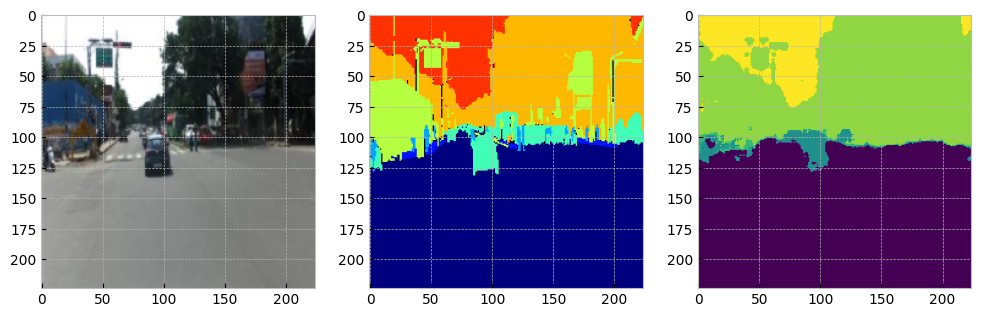

In [82]:
import random
img_batch_val, mask_batch_val = next(iter(val_dataloader))
idx = random.randint(0,BATCH_SIZE-1)
img = img_batch_val
mask = mask_batch_val[0]
output = model(img.cuda())
# PLotting one mask compared to the original one to understand if the process is working correctly
plt.figure(figsize=([12,8]))  # PLotting the image in a correct way 
img = img_batch_val[0]            # Getting the 1st image
img = np.transpose(img,(1,2,0))
#rescaled_pred = scipy.special.softmax(output,axis=1)
print(img_batch_val.shape)
rescaled_pred = torch.argmax(output[0,:,:,:],axis=0)   # only for inference
print(rescaled_pred.unique())

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(plot_combined_masks(mask)) 
plt.subplot(1,3,3)
plt.imshow(rescaled_pred.cpu())

## Output Tensor

Once we pass the input tensor into our trained model, we then need to apply softmax on the output tensor. After applying softmax, we then apply argmax to get which channel has the highest softmax-ed value among the 19 channels.

In [ ]:
# Apply softmax along dimension 0 (you can choose a different dimension if needed)
softmax_output = torch.nn.Softmax(dim=1)(model(x)[0,:,:,:])
print("Softmax output:", softmax_output)
min, max= torch.aminmax(softmax_output)
print(f"Range of the values; {min.item(),max.item()}")
# Find the index of the maximum value in the softmax output 
mask_softmax = torch.zeros_like(softmax_output)
#for i in range(0,softmax_output.shape(0)):
#    mask_softmax = 
rescale_mask = (softmax_output * 255).to(torch.uint8)
argmax = torch.argmax(softmax_output[0,:,:],dim=0)
rescale_mask.shape

Softmax output: tensor([[[0.0030, 0.0046, 0.0037,  ..., 0.0040, 0.0042, 0.0036],
         [0.0039, 0.0055, 0.0042,  ..., 0.0048, 0.0048, 0.0038],
         [0.0042, 0.0046, 0.0056,  ..., 0.0033, 0.0042, 0.0047],
         ...,
         [0.0050, 0.0038, 0.0052,  ..., 0.0045, 0.0043, 0.0037],
         [0.0039, 0.0038, 0.0044,  ..., 0.0039, 0.0041, 0.0041],
         [0.0039, 0.0044, 0.0042,  ..., 0.0040, 0.0044, 0.0051]]],
       grad_fn=<SoftmaxBackward0>)
Range of the values; (0.0006130404071882367, 0.022130843251943588)


torch.Size([1, 224, 224])